In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import pandas as pd
from consts import GAUSSIAN_METRICS
from utils import preprocess_agreement_score_dataset, squeezed_logit_transform, SORTER_NAMES, filter_dataframe_outliers

import matplotlib.pyplot as plt

def rbf(X, c, h):
    return np.exp(-(X - c).T * (X - c) / h)

In [2]:
data_path = '/home/mclancy/truespikes/data/static_tetrode_dataset.hd5'


In [3]:
data = preprocess_agreement_score_dataset(data_path)

sorter_idx = data[['sorterName']].applymap(lambda x: SORTER_NAMES.index(str(x).lower()))
data.drop(columns=['sorterName'], inplace=True)

Loaded from cache


/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


In [4]:
train_data, test_data = train_test_split(data,
    shuffle=True, test_size=0.2, stratify=sorter_idx
)

# print(train_data.shape)
# train_data = filter_dataframe_outliers(train_data, n_deviations=5)
# print(train_data.shape)

In [5]:
transformations = {'firing_rate': lambda x: np.log(x),
                   'snr': lambda x: np.sqrt(x),
                   'isolation_distance': lambda x: np.log(x + 0.00001),
                   'nn_hit_rate': squeezed_logit_transform,
                   'nn_miss_rate': squeezed_logit_transform,
                   'silhouette_score': lambda x: x,
                   'd_prime': lambda x: np.log(x + 0.00001),

                   'isi_violation': lambda x: x,
                   'amplitude_cutoff': lambda x: x,
                   'l_ratio': lambda x: x,
                   'presence_ratio': lambda x: x,

                   'agreement_score': squeezed_logit_transform,
                   }

transformed_train_data = pd.DataFrame(index=train_data.index, columns=data.columns)
transformed_test_data = pd.DataFrame(index=test_data.index, columns=data.columns)
for column in data.columns:
    if column in transformations:
        transformed_train_data[column] = transformations[column](train_data[column])
        transformed_test_data[column] = transformations[column](test_data[column])
    else:
        transformed_train_data[column] = train_data[column]
        transformed_test_data[column] = test_data[column]

In [6]:
standard_scalar = StandardScaler()
transformed_train_data[GAUSSIAN_METRICS] = standard_scalar.fit_transform(transformed_train_data[GAUSSIAN_METRICS])
transformed_test_data[GAUSSIAN_METRICS] = standard_scalar.transform(transformed_test_data[GAUSSIAN_METRICS])

In [7]:
print(transformed_train_data.shape)
transformed_train_data = filter_dataframe_outliers(
    transformed_train_data[GAUSSIAN_METRICS + ['agreement_score']], n_deviations=5
)
print(transformed_train_data.shape)

(7235, 16)
(7233, 8)


## Firing Rate
Expected to be log-normal (from MH), and as such a log transformation should give us an approximate normal.

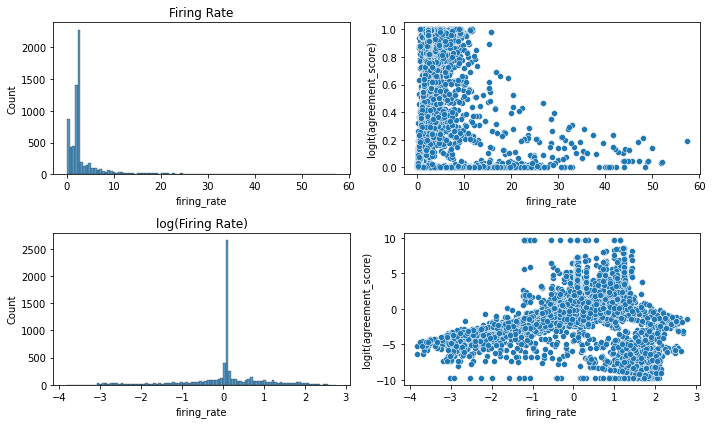

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
sns.histplot(train_data['firing_rate'], bins=100, ax=axes[0,0])
sns.scatterplot(x=train_data['firing_rate'], y=train_data['agreement_score'], ax=axes[0,1])
sns.histplot(transformed_train_data['firing_rate'], bins=100, ax=axes[1,0])
sns.scatterplot(x=transformed_train_data['firing_rate'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0,0].set_title(label='Firing Rate')
axes[1,0].set_title(label='log(Firing Rate)')
axes[0,1].set_ylabel('logit(agreement_score)')
axes[1,1].set_ylabel('logit(agreement_score)')
plt.tight_layout()
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/firing_rate_transformation_comparison.pdf')

## Presence Ratio
Unsure of how to deal with this, could turn into binary variable, seems to work well in the regression
Due to an off by one error this is never == 1. ( From Allensdk quality metrics description) NOT TRUE FOR THE DATA I HAVE,
have I lowered the precision of the data at some point?

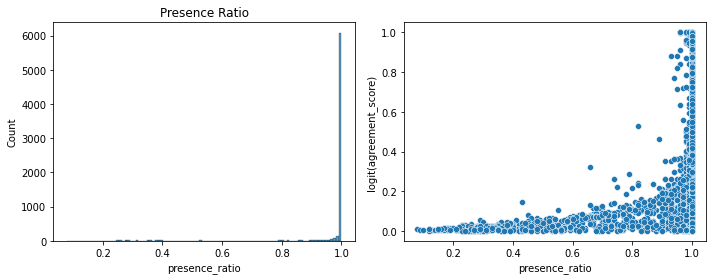

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.histplot(train_data['presence_ratio'], bins=100, ax=axes[0])
sns.scatterplot(x=train_data['presence_ratio'], y=train_data['agreement_score'], ax=axes[1])
# sns.histplot(transformed_train_data['presence_ratio'], bins=100, ax=axes[1,0])
# sns.scatterplot(x=transformed_train_data['presence_ratio'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0].set_title(label='Presence Ratio')
# axes[1,0].set_title(label='log(Firing Rate)')
axes[1].set_ylabel('logit(agreement_score)')
# axes[1,1].set_ylabel('logit(agreement_score)')
plt.tight_layout()

plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/presence_ratio_transformation_comparison.pdf')

## ISI Violations
Again, difficult to know how to deal with this, many values approx. equal to 0. With rest log distributed.

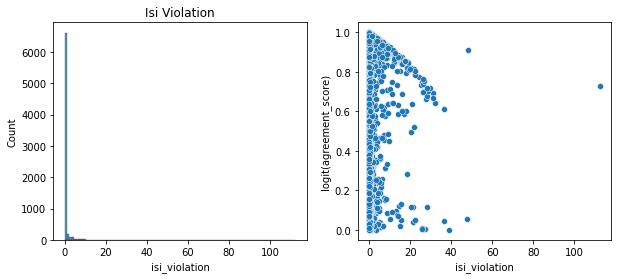

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.histplot(train_data['isi_violation'], bins=100, ax=axes[0])
sns.scatterplot(x=train_data['isi_violation'], y=train_data['agreement_score'], ax=axes[1])
# sns.histplot(transformed_train_data['isi_violation'], bins=100, ax=axes[1,0])
# sns.scatterplot(x=transformed_train_data['isi_violation'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0].set_title(label='Isi Violation')
axes[1].set_ylabel('logit(agreement_score)')
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/isi_violation_transformation_comparison.pdf')

In [11]:
# isi_violation_rbf_1 = rbf(train_data[METRIC_NAMES[2]], -11.7, 1)
# isi_violation_rbf_2 = rbf(train_data[METRIC_NAMES[2]], -1.8, 1)
#
# sns.scatterplot(isi_violation_rbf_1 + isi_violation_rbf_2, train_data['agreement_score'])

## Amplitude Cutoff

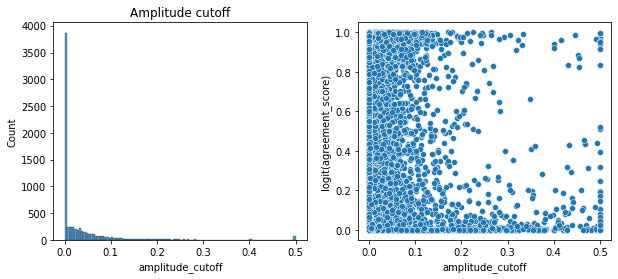

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.histplot(train_data['amplitude_cutoff'], bins=100, ax=axes[0])
sns.scatterplot(x=train_data['amplitude_cutoff'], y=train_data['agreement_score'], ax=axes[1])
# sns.histplot(transformed_train_data['amplitude_cutoff'], bins=100, ax=axes[1,0])
# sns.scatterplot(x=transformed_train_data['amplitude_cutoff'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0].set_title(label='Amplitude cutoff')
axes[1].set_ylabel('logit(agreement_score)')
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/amplitude_cutoff_transformation_comparison.pdf')


## SNR

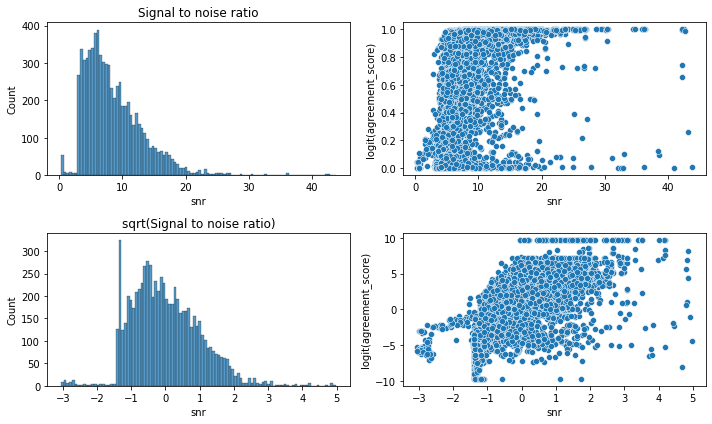

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
sns.histplot(train_data['snr'], bins=100, ax=axes[0,0])
sns.scatterplot(x=train_data['snr'], y=train_data['agreement_score'], ax=axes[0,1])
sns.histplot(transformed_train_data['snr'], bins=100, ax=axes[1,0])
sns.scatterplot(x=transformed_train_data['snr'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0,0].set_title(label='Signal to noise ratio')
axes[1,0].set_title(label='sqrt(Signal to noise ratio)')
axes[0,1].set_ylabel('logit(agreement_score)')
axes[1,1].set_ylabel('logit(agreement_score)')
plt.tight_layout()
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/snr_transformation_comparison.pdf')

## Silhouette Score

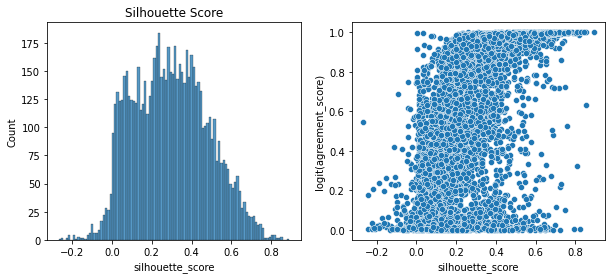

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.histplot(train_data['silhouette_score'], bins=100, ax=axes[0])
sns.scatterplot(x=train_data['silhouette_score'], y=train_data['agreement_score'], ax=axes[1])
# sns.histplot(transformed_train_data['silhouette_score'], bins=100, ax=axes[1,0])
# sns.scatterplot(x=transformed_train_data['silhouette_score'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0].set_title(label='Silhouette Score')
axes[1].set_ylabel('logit(agreement_score)')
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/silhouette_score_transformation_comparison.pdf')

## Isolation Distance
Not necessarily comparable across recordings dependent on the number of principal components of waveforms used to calculate.

Huge outliers here, lets view graph without values more than 3 stddev away.

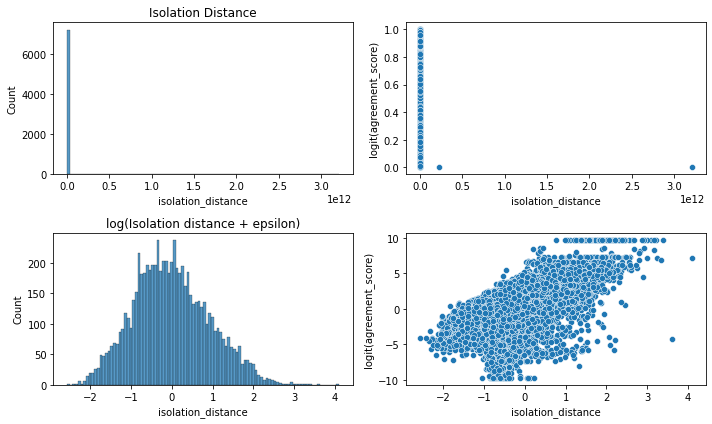

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
sns.histplot(train_data['isolation_distance'], bins=100, ax=axes[0,0])
sns.scatterplot(x=train_data['isolation_distance'], y=train_data['agreement_score'], ax=axes[0,1])
sns.histplot(transformed_train_data['isolation_distance'], bins=100, ax=axes[1,0])
sns.scatterplot(x=transformed_train_data['isolation_distance'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0,0].set_title(label='Isolation Distance')
axes[1,0].set_title(label='log(Isolation distance + epsilon)')
axes[0,1].set_ylabel('logit(agreement_score)')
axes[1,1].set_ylabel('logit(agreement_score)')
plt.tight_layout()
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/isolation_distance_transformation_comparison.pdf')

## L-Ratio

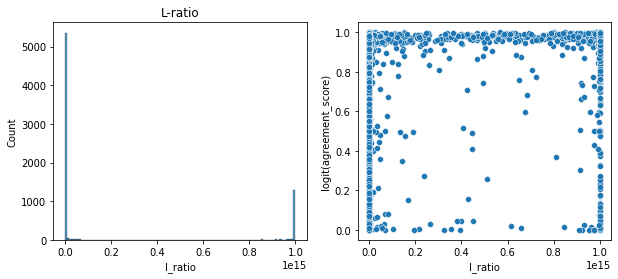

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.histplot(np.power(train_data['l_ratio'] + 0.00001, -3), bins=100, ax=axes[0])
sns.scatterplot(x=np.power(train_data['l_ratio'] + 0.00001, -), y=train_data['agreement_score'], ax=axes[1])
# sns.histplot(transformed_train_data['l_ratio'], bins=100, ax=axes[1,0])
# sns.scatterplot(x=transformed_train_data['l_ratio'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0].set_title(label='L-ratio')
axes[1].set_ylabel('logit(agreement_score)')
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/l_ratio_transformation_comparison.pdf')

## NN Hit Rate

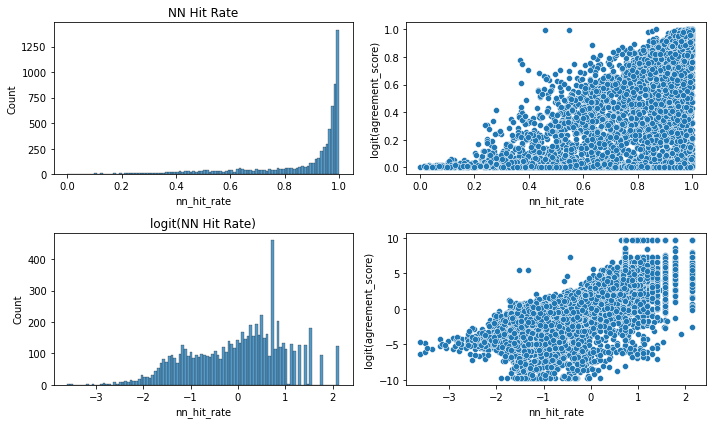

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
sns.histplot(train_data['nn_hit_rate'], bins=100, ax=axes[0,0])
sns.scatterplot(x=train_data['nn_hit_rate'], y=train_data['agreement_score'], ax=axes[0,1])
sns.histplot(transformed_train_data['nn_hit_rate'], bins=100, ax=axes[1,0])
sns.scatterplot(x=transformed_train_data['nn_hit_rate'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0,0].set_title(label='NN Hit Rate')
axes[1,0].set_title(label='logit(NN Hit Rate)')
axes[0,1].set_ylabel('logit(agreement_score)')
axes[1,1].set_ylabel('logit(agreement_score)')
plt.tight_layout()
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/nn_hit_rate_transformation_comparison.pdf')


## NN Miss Rate

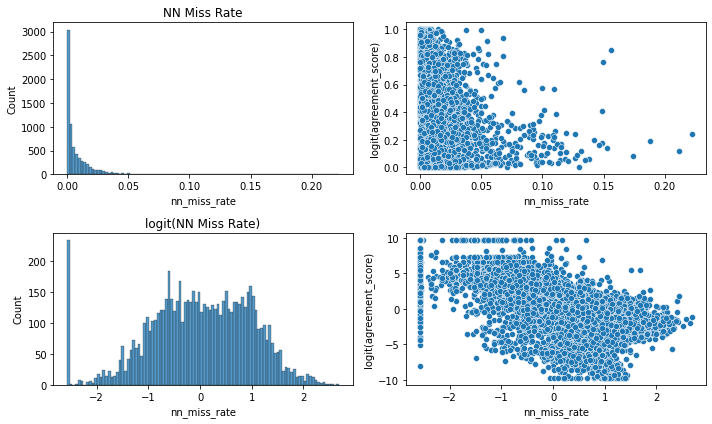

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
sns.histplot(train_data['nn_miss_rate'], bins=100, ax=axes[0,0])
sns.scatterplot(x=train_data['nn_miss_rate'], y=train_data['agreement_score'], ax=axes[0,1])
sns.histplot(transformed_train_data['nn_miss_rate'], bins=100, ax=axes[1,0])
sns.scatterplot(x=transformed_train_data['nn_miss_rate'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0,0].set_title(label='NN Miss Rate')
axes[1,0].set_title(label='logit(NN Miss Rate)')
axes[0,1].set_ylabel('logit(agreement_score)')
axes[1,1].set_ylabel('logit(agreement_score)')
plt.tight_layout()
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/nn_miss_rate_transformation_comparison.pdf')

## d-prime

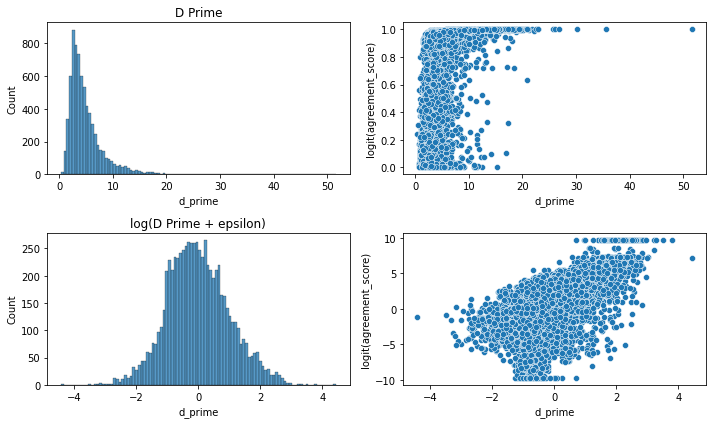

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
sns.histplot(train_data['d_prime'], bins=100, ax=axes[0,0])
sns.scatterplot(x=train_data['d_prime'], y=train_data['agreement_score'], ax=axes[0,1])
sns.histplot(transformed_train_data['d_prime'], bins=100, ax=axes[1,0])
sns.scatterplot(x=transformed_train_data['d_prime'], y=transformed_train_data['agreement_score'], ax=axes[1,1])
axes[0,0].set_title(label='D Prime')
axes[1,0].set_title(label='log(D Prime + epsilon)')
axes[0,1].set_ylabel('logit(agreement_score)')
axes[1,1].set_ylabel('logit(agreement_score)')
plt.tight_layout()
plt.savefig('/home/mclancy/truespikes/notebooks/figures/transformations/d_prime_transformation_comparison.pdf')